# LassoNet (Lemhadri et al, 2021)

Docs: https://lassonet.ml/

LassoNet is basically a residual feedfoward NN-architecture that enables structured feature selection using Lasso penalty. 

In [17]:
# import basic libraries
from datetime import datetime
import pandas as pd
import lassonet
from lassonet import LassoNetRegressor
from lassonet import plot_path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import wandb 
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: m-janyellow. Use `wandb login --relogin` to force relogin


True

## Define some basic helper and preprocessing functions

In [2]:
# Define data loader
def data_loader(data_path, pickle=True, parse_dates=False):
    # To-Do: include date parsing and set index to date/permno
    if not pickle:
      if parse_dates:
        dateparse = lambda x: pd.to_datetime(x, format='%Y-%m-%d', errors='coerce')
        data = pd.read_csv(root_path + data_path, index_col=["date","permno"],
                           parse_dates=['date'], date_parser=dateparse, skipinitialspace=True)
      else:
        data = pd.read_csv(root_path + data_path)
    else:
      data = pd.read_pickle(root_path + data_path)
    return data

In [3]:
root_path = "./data/"
subsample_path = 'subsample_processed_scaled.csv'
#subsample = data_loader(subsample_path, pickle=False, parse_dates=True)
#subsample.shape

In [11]:
data = data_loader(subsample_path, pickle=False)
data.columns

Index(['date', 'permno', 'cum_return_1_0', 'cum_return_6_2', 'cum_return_12_2',
       'cum_return_12_7', 'cum_return_36_13', 'investment', 'd_ceq', 'dpi2a',
       'd_shrout', 'ivc', 'noa', 'ato', 'cto', 'd_dgm_dsales', 'eps', 'ipm',
       'pcm', 'pm', 'pm_adj', 'prof', 'rna', 'roa', 'roc', 'roe', 'roic',
       's2c', 'sat', 'at_adj', 'aoa', 'ol', 'tan', 'oa', 'a2me', 'beme',
       'beme_adj', 'c', 'c2d', 'd_so', 'debt2p', 'e2p', 'free_cf', 'ldp',
       'nop', 'o2p', 'q', 's2p', 'sales_g', 'at', 'beta', 'beta_daily', 'dto',
       'idio_vol', 'lme', 'lme_adj', 'lturnover', 'rel_to_high_price',
       'ret_max', 'spread_mean', 'std_turn', 'std_volume', 'suv', 'total_vol',
       'ret', 'yy', 'mm_cos', 'mm_sin', 'stock', 'TARGET'],
      dtype='object')

In [4]:
# Load full dataset with multiindex enabled
fullsample_path = 'data_processed_scaled.csv'
#data = data_loader(fullsample_path, pickle=False, parse_dates=True)
#data.shape

In [5]:
def normalize_target(data):
    scaler = StandardScaler()
    target = data.TARGET.values.reshape(-1, 1)
    #print(target.shape)
    data['TARGET'] = scaler.fit_transform(target)
    return data

In [11]:
## Inspect target vbl
import random
#subsample.TARGET.describe()
permnos_total = subsample.index.droplevel(['date'])
sample_permno = random.choice(permnos_total) # ramdom stock selected

# get and inspect distribution of target of that one
single_stock = subsample.xs(sample_permno, level='permno')
single_stock.TARGET.describe()

NameError: name 'subsample' is not defined

In [27]:
# feature selector
features_wo_months = ['cum_return_1_0', 'cum_return_6_2', 'cum_return_12_2',
       'cum_return_12_7', 'cum_return_36_13', 'investment', 'd_ceq', 'dpi2a',
       'd_shrout', 'ivc', 'noa', 'ato', 'cto', 'd_dgm_dsales', 'eps', 'ipm',
       'pcm', 'pm', 'pm_adj', 'prof', 'rna', 'roa', 'roc', 'roe', 'roic',
       's2c', 'sat', 'at_adj', 'aoa', 'ol', 'tan', 'oa', 'a2me', 'beme',
       'beme_adj', 'c', 'c2d', 'd_so', 'debt2p', 'e2p', 'free_cf', 'ldp',
       'nop', 'o2p', 'q', 's2p', 'sales_g', 'at', 'beta', 'beta_daily', 'dto',
       'idio_vol', 'lme', 'lme_adj', 'lturnover', 'rel_to_high_price',
       'ret_max', 'spread_mean', 'std_turn', 'std_volume', 'suv', 'total_vol',
       'ret', 'yy', 'stock', 'TARGET']

## Simple Train / test split

Split data only once into train, valid and test set

In [6]:
def data_splitter(data, end_of_training="1985-12-31", end_of_validation="1990-12-31"):
    # define start of training
    start_of_training = data.index.get_level_values(0).min()
    
    # isolate y from data set
    X = data.iloc[:,:-1]
    y = data.TARGET
    
    # define initial training and test window
    train_window = pd.date_range(start=start_of_training, end=end_of_training, freq="M")
    train_window = len(train_window)

    # slice to required size
    X_train = X.loc[pd.IndexSlice[start_of_training:end_of_training,], :]
    y_train = y.loc[pd.IndexSlice[start_of_training:end_of_training,]]
    X_valid = X.loc[pd.IndexSlice[end_of_training:end_of_validation,], :]
    y_valid = y.loc[pd.IndexSlice[end_of_training:end_of_validation,]]
    X_test = X.loc[pd.IndexSlice[end_of_validation:,], :]
    y_test = y.loc[pd.IndexSlice[end_of_validation:,]]
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test

### Hyperparameter tuning
(https://towardsdatascience.com/bayesian-optimization-for-hyperparameter-tuning-how-and-why-655b0ee0b399)

In [7]:
# Lets try Bayesian search first
X_train, X_test, _, y_train, y_test, _ = data_splitter(subsample)

from skopt import BayesSearchCV
from datetime import datetime

NameError: name 'subsample' is not defined

In [15]:
# TO-DO: adjust!
# Bayesian Search for hyperparm tuning
n_iter = 10

param_grid = {
    "learning_rate": (0.0001, 0.1, "log-uniform"),
    "hidden_dims" : [d/3, 2*d/3, d, 4*d/3]
}

reg_bay = BayesSearchCV(estimator=ExplainableBoostingRegressor(random_state=0, n_jobs=-1),
                    search_spaces=param_grid,
                    n_iter=n_iter,
                    cv=5,
                    n_jobs=8,
                    scoring='neg_mean_squared_error',
                    random_state=0)

start_time = datetime.now()

# Run Bayes Search (this takes a while)
#model_bay = reg_bay.fit(X_train, y_train)

execution_time = (datetime.now() - start_time).total_seconds()
print(f"Optimization took {np.round(execution_time/60),2} minutes.")

Optimization took (0.0, 2) minutes.


In [ ]:
# model_bay
#X_train, X_test, _, y_train, y_test, _ = data_splitter(subsample)

# model can be saved, used for predictions or scoring
best_parms = model_bay.best_params_
best_score = model_bay.best_score_
best_estimator = model_bay.best_estimator_
cv_results = model_bay.cv_results_
print(f"Best params are: {best_parms} \n with best score of {best_score} ")

Best params are: OrderedDict([('early_stopping_rounds', 37), ('early_stopping_tolerance', 0.00020919480782183626), ('learning_rate', 0.000609840586504895), ('max_bins', 230), ('max_rounds', 3000)]) 
 with best score of -0.012216270250622302 


## Train and Validate Model

In [20]:
# helper to isolate y from data set
def isolate_target(data):
    X = data.iloc[:,:-1]
    #print(X)
    y = data.TARGET
    return X, y

In [19]:
def feature_selector(data, selectors):
    return data.loc[:,selectors]

In [22]:
def train_model(model, X_train, y_train, tune=False, param_dict={}):
    if tune:
        print("model is being tuned")
        model.set_params(**param_dict)
    model.fit(X_train, y_train)
    return model

def validate_model(model, X_valid, y_valid):
    return model.score(X_valid, y_valid) # validation set R²

def rmse(y_test, y_pred):
    rmse_ = np.sqrt(((y_test - y_pred)**2).mean())  # np.sqrt(((predictions - targets) ** 2).mean())
    return rmse_

def visualize_feature_selection(model, X_test, y_test):
    plot_path(model, path, X_test, y_test)
    plt.savefig(f'{results_dir}Lassonet_path_{run_id}')
    
def df_to_array(X_train, X_test, y_train, y_test):
    X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values
    return X_train, X_test, y_train, y_test

In [23]:
def plot_feature_importance(X, model, feature_names, run_id=1):
    
    n_features = X.shape[1]
    importances = model.feature_importances_.numpy()
    order = np.argsort(importances)[::-1]
    importances = importances[order]
    ordered_feature_names = [feature_names[i] for i in order[:30]] # show the first 30

    w = round(n_features*0.6)
    h = round(n_features*0.4)
    plt.figure(figsize=(w,h))

    plt.subplot(211)
    plt.bar(
        np.arange(n_features),
        importances,
        #color=color,
    )
    plt.xticks(np.arange(n_features), ordered_feature_names, rotation=90)
    #colors = {"real features": "g", "fake features": "r"}
    #labels = list(colors.keys())
    #handles = [plt.Rectangle((0, 0), 1, 1, color=colors[label]) for label in labels]
    #plt.legend(handles, labels)
    plt.ylabel("Feature importance")

    plt.savefig(f"feature_importance_plot_{run_id}.png")

## Pipeline - bring it all together!

In [24]:
def pipeline(data_name, pickle, date_parse, model=LassoNetRegressor(random_state=0, verbose=True), 
             tune=False, feature_selection=[], param_dict={}):
    # init training run
    wandb.init(project="interpretable-ml", group="lassonet-studies")
    # start timer for total run time
    start_time = datetime.now()
    
    # load an split data sets
    data = data_loader(data_name, pickle, date_parse)
    if len(feature_selection)>=1:
          data = feature_selector(data, feature_selection) 
    data = normalize_target(data)
    X_train, X_valid, X_test, y_train, y_valid, y_test = data_splitter(data)
    # bring data to array
    X_train, X_test, y_train, y_test = df_to_array(X_train, X_valid, y_train, y_valid)
    
    # train the model
    fitted_model = train_model(model, X_train, y_train, tune, param_dict)
    
    # plot feat selection path
    visualize_feature_selection(fitted_model, X_test, y_test)
    
    # evaluate model perdormance
    params = fitted_model.get_params()
    is_score = validate_model(model, X_train, y_train)
    oos_score = validate_model(model, X_test, y_test)
    y_pred = fitted_model.predict(X_test)
    rmse_test = rmse(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test,y_pred)
    n_features = X_train.shape[1]
    
    # finish training
    execution_time = (datetime.now() - start_time).total_seconds()
    wandb.log({"mse" : mse, "rmse" : rmse_test, "mae" : mae, "n_features": n_features, 
               "time_spent" : execution_time, "Model Params" : params})
    wandb.finish()
    return execution_time, is_score, oos_score, mae, mse, rmse_test, params, X_valid, y_valid, y_pred, fitted_model

## First experiment: all features, but sampled permnos

In [17]:
# load an split data sets
data = data_loader(subsample_path, pickle=False, parse_dates=True)
data = normalize_target(data)
X_train, X_valid, X_test, y_train, y_valid, y_test = data_splitter(data)
# bring data to array
X_train, X_test, y_train, y_test = df_to_array(X_train, X_valid, y_train, y_valid)

## trial run#
model = LassoNetRegressor(hidden_dims=(50,), verbose=True, patience=(100, 5))
path = model.path(X_train, y_train)

Initialized dense model in 159 epochs, val loss 7.60e-01, regularization 2.93e+00
Lambda = 7.60e-01, selected 67 features in 5 epochs
val_objective 3.01e+00, val_loss 7.66e-01, regularization 2.95e+00
Lambda = 7.75e-01, selected 67 features in 100 epochs
val_objective 1.86e+00, val_loss 7.81e-01, regularization 1.39e+00
Lambda = 7.91e-01, selected 67 features in 5 epochs
val_objective 1.87e+00, val_loss 7.81e-01, regularization 1.37e+00
Lambda = 8.07e-01, selected 67 features in 5 epochs
val_objective 1.87e+00, val_loss 7.80e-01, regularization 1.36e+00
Lambda = 8.23e-01, selected 67 features in 5 epochs
val_objective 1.88e+00, val_loss 7.80e-01, regularization 1.34e+00
Lambda = 8.39e-01, selected 67 features in 5 epochs
val_objective 1.89e+00, val_loss 7.80e-01, regularization 1.32e+00
Lambda = 8.56e-01, selected 67 features in 5 epochs
val_objective 1.90e+00, val_loss 7.79e-01, regularization 1.31e+00
Lambda = 8.73e-01, selected 67 features in 5 epochs
val_objective 1.91e+00, val_los

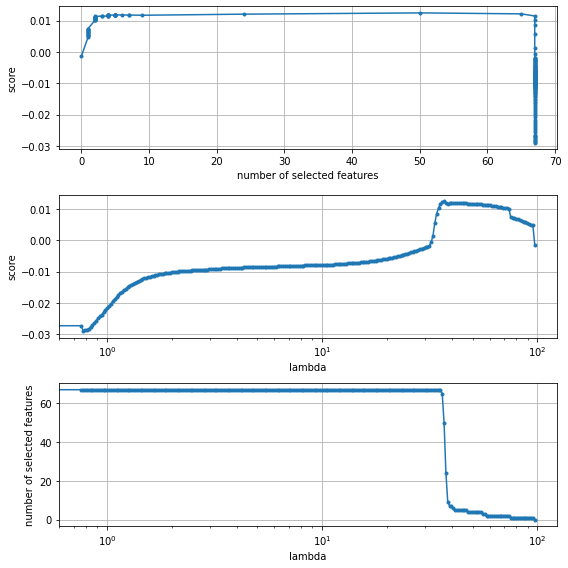

In [20]:
# plot 
plot_path(model, path, X_test, y_test)

In [31]:
path

[HistoryItem(lambda_=0, state_dict={'layers.0.weight': tensor([[-0.0728,  0.0218,  0.0802,  ..., -0.0106,  0.0624,  0.0331],
         [-0.1229,  0.0141, -0.0225,  ...,  0.0259, -0.0921, -0.0838],
         [-0.0352, -0.0505, -0.0140,  ..., -0.2520, -0.1382, -0.0144],
         ...,
         [-0.0022, -0.1438, -0.0255,  ..., -0.1619, -0.0614,  0.0429],
         [ 0.1322, -0.0204, -0.0890,  ..., -0.0207, -0.0066,  0.1308],
         [-0.0298, -0.0179,  0.1393,  ...,  0.0537, -0.0945,  0.1781]]), 'layers.0.bias': tensor([-0.0646,  0.1441,  0.0466,  0.0642,  0.0966,  0.0955,  0.0078, -0.1458,
          0.0113, -0.0807,  0.0732,  0.0922,  0.1298,  0.0382, -0.1475, -0.1179,
         -0.0679, -0.0981,  0.1510,  0.0153,  0.0599,  0.1561, -0.0896,  0.0583,
         -0.0775,  0.1811, -0.0716, -0.0420, -0.0628,  0.1096, -0.0166,  0.0213,
         -0.0288, -0.0456, -0.0269, -0.1453,  0.0152,  0.0621,  0.1058,  0.0600,
         -0.0357,  0.0350,  0.1163, -0.0450,  0.1305, -0.0134, -0.0685, -0.0025,
  

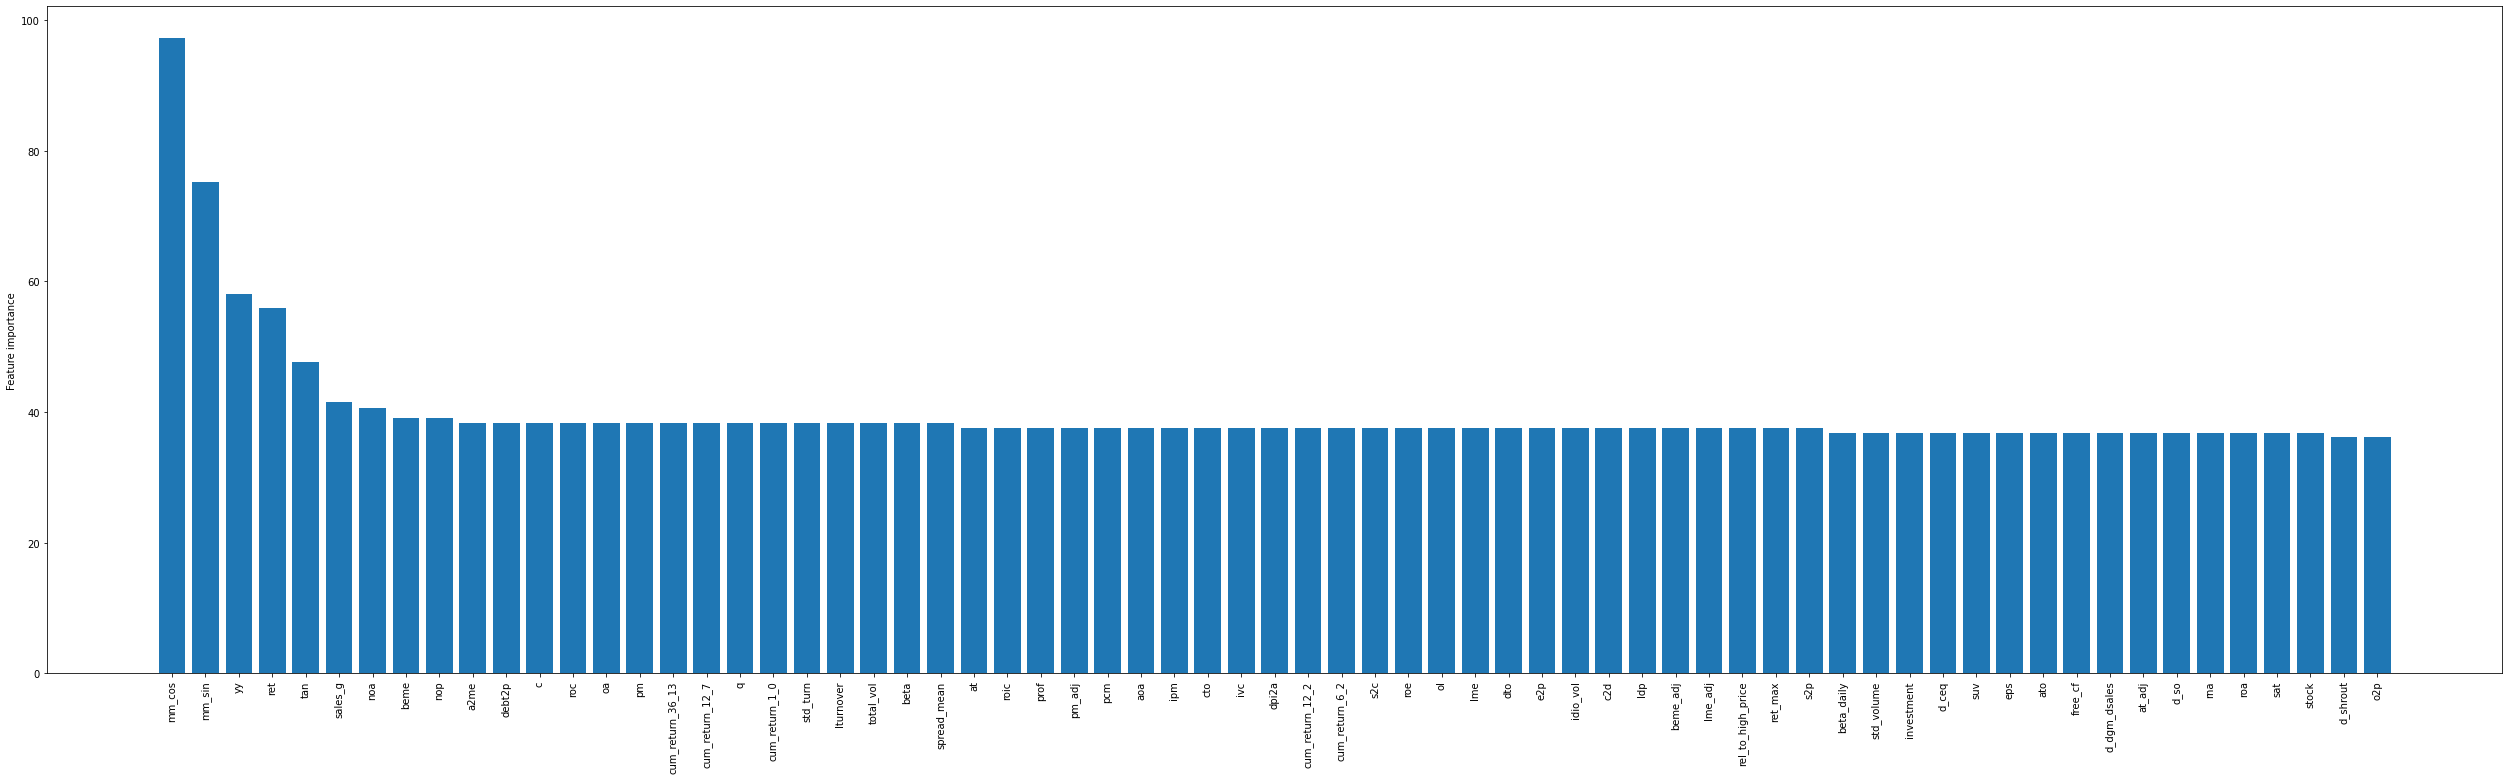

In [30]:
feature_names = data.iloc[:,:-1].columns
plot_feature_importance(X_train, model, feature_names, run_id=1)

In [43]:
len(feature_names)

68

In [44]:
sel_epochs = []
feat_selection = {"epoch" : [],
                 "features" : []}
feature_names = data.iloc[:,:-1].columns
i = 0
for epoch in path:
    num_feats = int(sum(epoch.selected))
    sel_epochs.append(num_feats)
    if num_feats < 67:
        feat_selection["epoch"].append(i)
        feat_selection["features"].append(list(feature_names[epoch.selected]))
    i+=1

In [32]:
# extract loss-history
history_val = []
history = []
for epoch in path:
    loss = epoch.loss
    val_loss = epoch.val_loss
    history_val.append(val_loss)
    history.append(loss)

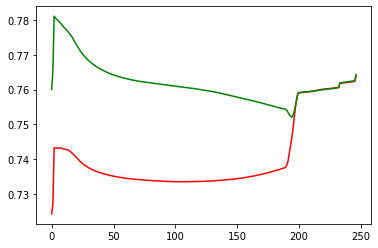

In [34]:
plt.plot(history, c="r")
plt.plot(history_val, c="g")

## Experiment 2: without month features

In [33]:
# run pipeline using all but month features
results_dir = './results/'
run_id = '02'

# load an split data sets
data = data_loader(subsample_path, pickle=False, parse_dates=True)
data = normalize_target(data)
X_train, X_valid, X_test, y_train, y_valid, y_test = data_splitter(data)

# bring data to array
X_train, X_test, y_train, y_test = df_to_array(X_train, X_valid, y_train, y_valid)

## trial run#
start_time = datetime.now()
model = LassoNetRegressor(hidden_dims=(100,), verbose=True, patience=(100, 5), batch_size=256, dropout=0.4, random_state=0)
path = model.path(X_train, y_train)
execution_time = round((datetime.now() - start_time).total_seconds())
print(f"Finished training in {execution_time} secs.")

Initialized dense model in 121 epochs, val loss 7.89e-01, regularization 1.55e+00
Lambda = 7.89e-01, selected 67 features in 5 epochs
val_objective 2.64e+00, val_loss 8.03e-01, regularization 2.33e+00
Lambda = 8.05e-01, selected 67 features in 48 epochs
val_objective 2.11e+00, val_loss 7.96e-01, regularization 1.63e+00
Lambda = 8.21e-01, selected 67 features in 18 epochs
val_objective 2.05e+00, val_loss 8.04e-01, regularization 1.51e+00
Lambda = 8.38e-01, selected 67 features in 23 epochs
val_objective 1.96e+00, val_loss 7.90e-01, regularization 1.40e+00
Lambda = 8.54e-01, selected 67 features in 7 epochs
val_objective 1.96e+00, val_loss 7.90e-01, regularization 1.37e+00
Lambda = 8.72e-01, selected 67 features in 9 epochs
val_objective 1.95e+00, val_loss 7.90e-01, regularization 1.33e+00
Lambda = 8.89e-01, selected 67 features in 9 epochs
val_objective 1.96e+00, val_loss 8.02e-01, regularization 1.30e+00
Lambda = 9.07e-01, selected 67 features in 8 epochs
val_objective 1.95e+00, val_lo

KeyboardInterrupt: 

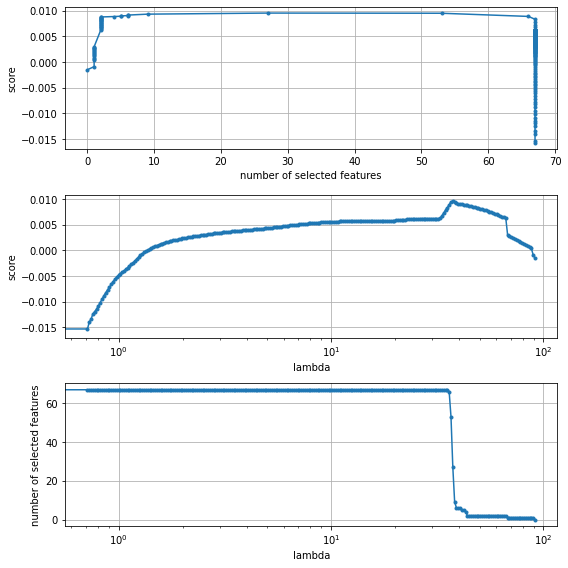

In [31]:
plot_path(model, path, X_test, y_test)

In [32]:
print("Best model scored", model.score(X_test, y_test))
print("Lambda =", model.best_lambda_)

Best model scored -0.0014814291294054094


AttributeError: 'LassoNetRegressor' object has no attribute 'best_lambda_'

## Use all data

In [ ]:
# load an split data sets
all_data = data_loader(fullsample_path, pickle=False, parse_dates=True)
all_data = normalize_target(data)
X_train, X_valid, X_test, y_train, y_valid, y_test = data_splitter(all_data)
# bring data to array
X_train, X_test, y_train, y_test = df_to_array(X_train, X_valid, y_train, y_valid)

## trial run#
model = LassoNetRegressor(hidden_dims=(50,), verbose=True, patience=(100, 5))
path = model.path(X_train, y_train)

In [ ]:
###

In [ ]:
fullsample_path

## Some more modelling on various data sets

In [21]:
### Helper method to visualize prediction vs true values
import matplotlib.pyplot as plt
import random
plt.style.use("seaborn")

permnos_total = subsample.index.droplevel(['date'])

def visualize_sample_prediction(y_test, y_pred):
    # Picks a random stock, to visualize its real returns 
    # against the predicted returns
    sample_permno = random.choice(permnos_total)
    ## delete:
    #sample_permno = 51625
    sample_test_y = y_test.xs(sample_permno, level='permno')
    
    sample_test_idx = sample_test_y.index.get_level_values('date')
    
    y_pred = pd.Series(y_pred, index=y_test.index)
    sample_pred = y_pred.xs(sample_permno, level='permno')
    
    
    fig,ax=plt.subplots(figsize=(18,6))

    ax.scatter(x=sample_test_idx, y= sample_test_y, color='r')
    ax.scatter(x=sample_test_idx, y= sample_pred, color='b')
    plt.title(f'Stock nr {sample_permno} predicted returns (blue) vs actual returns (red)')

In [25]:
## best features found by random forrest reg
features_rf = ['d_shrout', 'roe', 'oa', 'free_cf', 'nop', 'dpi2a', 'rna', 'ato', 'd_dgm_dsales', 'roc', 'ipm', 'spread_mean', 'dto', 'suv', 'TARGET']

In [32]:
## best features used by freyberger et al:
features_freyberger = ['d_shrout', 'd_so', 'investment', 'lme', 'lturnover', 'pm_adj', 'cum_return_1_0', 'cum_return_12_2', 'cum_return_12_7', 'rel_to_high_price', 'roc','suv', 'total_vol','TARGET']

In [42]:
features_ae = ['e2p', 'beme', 'cum_return_12_2', 'cum_return_12_7', 'mm_sin', 'mm_cos', 'yy', 'dpi2a', 'ret', 'total_vol', 'noa', 'std_volume', 'cto', 'TARGET']
#pipe_run_4 = list(pipeline(subsample_path, feature_selection=features_ae))

In [39]:
features_adhoc = ['yy', 'cum_return_12_7', 'ret', 'd_so', 'mm_sin', 'suv', 'd_shrout', 'mm_cos', 'rna', 'stock', 'TARGET']
features_few = ['yy',  'ret', 'mm_sin', 'd_shrout', 'mm_cos', 'stock', 'TARGET']

### Use Union of features from three selection methods (RF, freyberger, AE)

In [ ]:
# Without repetition 
def union(lst1, lst2, lst3):
    final_list = list(set(lst1) | set(lst2) | set(lst3))
    return final_list

In [ ]:
a = features_ae
b = features_freyberger
c = features_rf
features_comb = union(a,b,c)
features_comb.remove("TARGET")
print(features_comb)

['ato', 'yy', 'spread_mean', 'cum_return_12_7', 'ret', 'd_so', 'd_dgm_dsales', 'lturnover', 'roe', 'mm_sin', 'ipm', 'dpi2a', 'beme', 'nop', 'lme', 'suv', 'dto', 'noa', 'd_shrout', 'total_vol', 'free_cf', 'cum_return_1_0', 'mm_cos', 'roc', 'e2p', 'oa', 'cto', 'rna', 'pm_adj', 'std_volume', 'rel_to_high_price', 'cum_return_12_2', 'investment']


In [ ]:
features_combined = ['ato', 'yy', 'spread_mean', 'cum_return_12_7', 'ret', 'd_so', 'd_dgm_dsales', 'lturnover', 'roe', 'mm_sin', 'ipm', 'dpi2a', 'beme', 'nop', 'lme', 'suv', 'dto', 'noa', 'd_shrout', 'total_vol', 'free_cf', 'cum_return_1_0', 'mm_cos', 'roc', 'e2p', 'oa', 'cto', 'rna', 'pm_adj', 'std_volume', 'rel_to_high_price', 'cum_return_12_2', 'investment', 'TARGET']

## California Housing dataset

In [39]:
print(X.shape, " // ", y.shape )

(20640, 8)  //  (20640,)


In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
import numpy as np

from lassonet import LassoNetRegressor

dataset = fetch_california_housing() 
X = dataset.data
y = dataset.target
_, true_features = X.shape

# add dummy feature
X = np.concatenate([X, np.random.randn(*X.shape)], axis=1)
feature_names = list(dataset.feature_names) + ["fake"] * true_features

# standardize
X = StandardScaler().fit_transform(X)
y = scale(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = LassoNetRegressor(hidden_dims=(10,), verbose=True, patience=(100, 5))
path = model.path(X_train, y_train)

Initialized dense model in 1000 epochs, val loss 3.14e-01, regularization 9.81e-01
Lambda = 3.14e-01, selected 16 features in 5 epochs
val_objective 6.61e-01, val_loss 3.11e-01, regularization 1.12e+00
Lambda = 3.21e-01, selected 16 features in 5 epochs
val_objective 6.64e-01, val_loss 3.10e-01, regularization 1.10e+00
Lambda = 3.27e-01, selected 16 features in 5 epochs
val_objective 6.66e-01, val_loss 3.10e-01, regularization 1.09e+00
Lambda = 3.34e-01, selected 16 features in 5 epochs
val_objective 6.69e-01, val_loss 3.10e-01, regularization 1.08e+00
Lambda = 3.40e-01, selected 16 features in 5 epochs
val_objective 6.72e-01, val_loss 3.10e-01, regularization 1.06e+00
Lambda = 3.47e-01, selected 16 features in 5 epochs
val_objective 6.75e-01, val_loss 3.10e-01, regularization 1.05e+00
Lambda = 3.54e-01, selected 16 features in 5 epochs
val_objective 6.79e-01, val_loss 3.10e-01, regularization 1.04e+00
Lambda = 3.61e-01, selected 16 features in 5 epochs
val_objective 6.82e-01, val_loss

In [54]:
print(X.columns)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

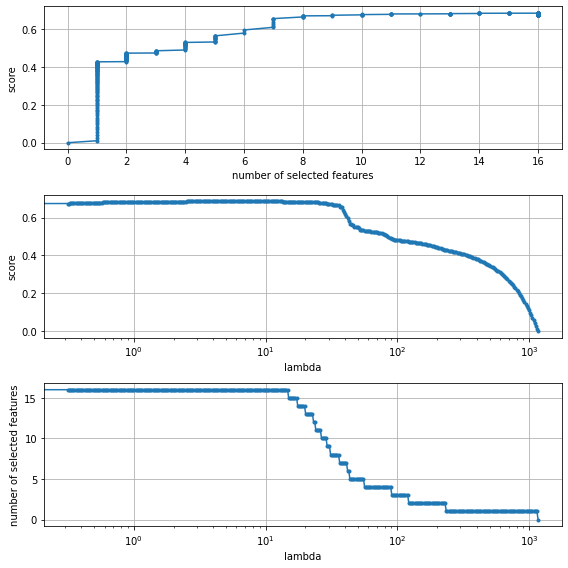

In [53]:
plot_path(model, path, X_test, y_test)

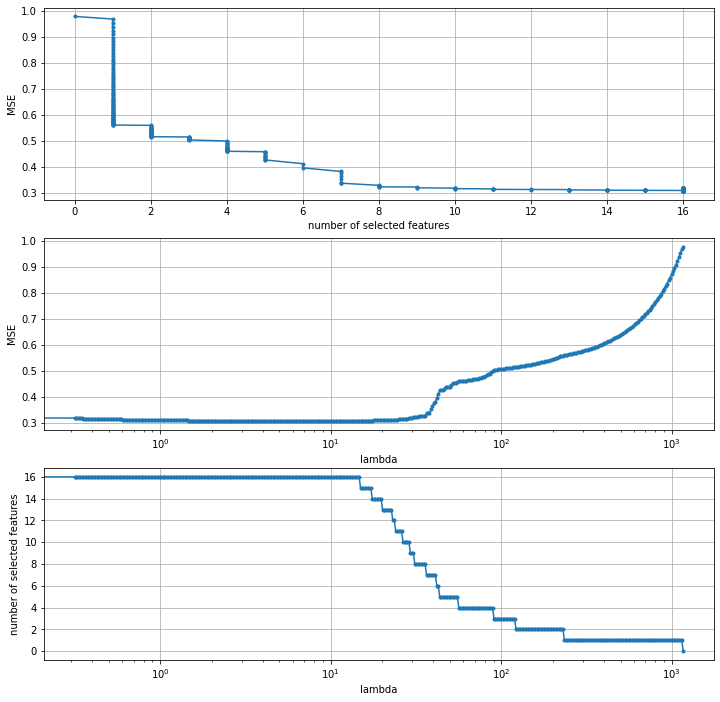

In [46]:
# Visualize Feature Selection path
n_selected = []
mse = []
lambda_ = []

for save in path:
    model.load(save.state_dict)
    y_pred = model.predict(X_test)
    n_selected.append(save.selected.sum().cpu().numpy())
    mse.append(mean_squared_error(y_test, y_pred))
    lambda_.append(save.lambda_)

fig = plt.figure(figsize=(12, 12))

plt.subplot(311)
plt.grid(True)
plt.plot(n_selected, mse, ".-")
plt.xlabel("number of selected features")
plt.ylabel("MSE")

plt.subplot(312)
plt.grid(True)
plt.plot(lambda_, mse, ".-")
plt.xlabel("lambda")
plt.xscale("log")
plt.ylabel("MSE")

plt.subplot(313)
plt.grid(True)
plt.plot(lambda_, n_selected, ".-")
plt.xlabel("lambda")
plt.xscale("log")
plt.ylabel("number of selected features")

plt.savefig("./results/lassonet/california-select-features.png")

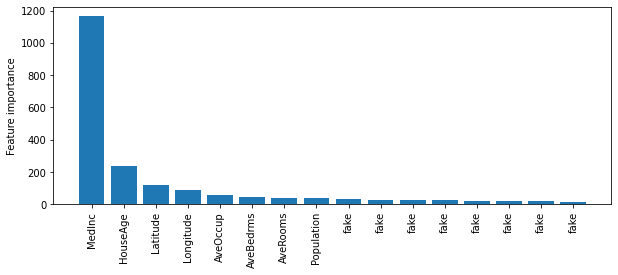

In [66]:
plot_feature_importance(X, model, feature_names)